# Comparison of reference matching algorithms

Dominika Tkaczyk

13.10.2018

This file contains the comparison of two approaches to bibliographic reference matching:
  * **STQ**: the currently used matching approach
  * **SBM**: search-based matching

STQ is Crossref's current matching algorithm. STQ internally uses a 3rd party parser and regular expressions and queries Oracle. I run this matching algorithm using [Simple Text Query form](https://apps.crossref.org/SimpleTextQuery/).

SBM is a new idea, based on the search functionality of Crossref REST API. It is a very simple algorithm, which doesn't include any reference parsing step. In SBM the entire reference string is used as a query in REST API. The first hit is returned as the matched target document, if its relevance score is high enough. If the relevance score of the first hit is low, no target DOI is assigned and the reference string stays unmatched.

The goal of this analysis is to evaluate and compare both STQ and SBM.

## TL;DR

  * A large automatically generated dataset was used for the experiments. It is composed of 7374 real metadata records, each of which was formatted automatically into reference strings using 11 citation styles.
  * The main metrics used for the evaluation are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). I use [F1](https://en.wikipedia.org/wiki/F1_score) as a standard metric that combines precision and recall into a single number, weighing them equally.
  * Two variations of SBM were tested: SBM with a simple relevance threshold of 53 and SBM with a normalized relevance threshold of 0.47 (more about the thresholds and how their values were calculated can be found [here](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/relevance_threshold.ipynb)).
  * In general, STQ is slightly better than SBM in precision, but much worse in recall and F1.
  * Both variations of SBM outperform STQ in terms of F1:
    * SBM with a simple threshold: F1 76% vs. 49% (precision: 98.4% vs. 99.3%; recall 68% vs. 38%)
    * SBM with a normalized threshold: F1 81% vs. 49% (precision: 98.1% vs. 99.3%; recall 75% vs. 38%)
  * SBM with a simple threshold outperforms STQ in 8 citation styles out of 11.
  * SBM with a normalized threshold outperforms STQ in all 11 citation styles.
  * Weak spot of STQ are degraded/noisy reference strings, which do not appear to use any of the known citation style.
  * Weak spot of SBM are short reference strings, and in particular citation styles that do not include the title in the string.

## Methodology

We need two things to evaluate and compare the algorithms: the dataset and the metrics.

### The dataset

The dataset used for the experiments was generated automatically using the following workflow.

First, I took a random sample of 2500 items from the system. (This number was chosen as big enough to give reliable results and small enough to handle the current STQ form limits.) This is my base sample.

Second, I extended the sample by adding up to 2 similar documents for each item in the sample. Similar documents were found by selecting the highest hits from the search results. As a search query I used the concatenation of the title, container title and family names of all the authors. This step was performed to increase the probability of incorrect links pointing to the base sample (i.e. to have a non-zero false positive rate). Extending the dataset resulted in 7374 items in total (fewer than 3 x the original sample size, because for some documents fewer than 2 similar documents could be found).

Next, reference strings were generated for all items. In this experiment, I used the following 11 styles:
  * normal styles:
    * **american-chemical-society**
    * **american-institute-of-physics**
    * **elsevier-without-titles**
    * **apa**
    * **chicago-author-date**
    * **modern-language-association**
  * normal styles + random noise added to the reference strings (additional spaces, missing spaces, typos):
    * **apa+noise**
    * **american-institute-of-physics+noise**
  * custom "styles":
    * **degraded_all_authors**: a simple concatenation of authors' names, title and container title
    * **degraded_one_author**: a simple concatenation of the first author's name, title and container title
    * **degraded_title_scrambled**: same as degraded_all_authors, but with the title words randomly shuffled

Finally, each string was passed to both reference matching algorithms and the returned matched DOIs were recorded. For SBM I also kept the resulting relevance scores, so that it is possible to later apply any relevance score threshold.

Note that this workflow resembles what a lot of authors do when they compile the bibliographies for their papers (finding the metadata of the cited paper in a digital repository, and using a tool to format the metadata using a specified citation style). As a result, even though the reference strings we have in the dataset are not strings we actually came across in the live system, they could easily appear in a scientific paper, which makes the dataset more realistic. 

### The metrics


To evaluate and compare the algorithms, I used averaged document-based metrics. More specifically, for each document from the base sample the following metrics are calculated:
  * **precision**: what fraction of links to document X returned by the matching algorithm are correct (or: what is the probability that the link to document X returned by the algorithm is correct)
  * **recall**: what fraction of true expected links to document X were returned by the algorithm (or: what is the probability that the true link to document X will be returned by the algorithm)
  * **F1**: harmonic mean of precision and recall. F1 is a standard metric, used in information retrieval to combine precision and recall into a single number, weighing them equally. A more generic version of this metric, called F-measure, can be used to place more emphasis on either precision or recall. In these experiments I am using a balanced version.

These numbers are then averaged over all 2500 documents from the base sample. The averages can be treated as single-number metrics, and the distributions of the results over the documents allow to calculate the confidence intervals. 

More information about the metrics can be found [here](https://docs.google.com/document/d/1X0clkjH-HM3DLVPWDgAZgS97Th4slniq28F9o-yd53k). More information about the foundations of sampling and confidence intervals can be found in [this notebook](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/sampling_notes.ipynb)

## Results

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from evaluation.document_metrics import ByDocumentMetricsResults
from evaluation.split_metrics import SplitByRefAttrResults
from utils.utils import read_json

DATA_DIR = '../data/comparison/'
STYLES = ['american-chemical-society', 'american-institute-of-physics', 'american-institute-of-physics-noise', 'apa',
          'apa-noise', 'chicago-author-date', 'degraded_all_authors', 'degraded_one_author',
          'degraded_title_scrambled', 'elsevier-without-titles', 'modern-language-association']

Let's read the data:

In [2]:
def read_data(algorithm):
    dataset = []
    for style in STYLES:
        d = read_json(DATA_DIR + 'matched/matched-' + algorithm + '-' + style + '.json')
        dois = d[dfk.DATASET_DOIS]
        dataset.extend(d[dfk.DATASET_DATASET])
    return dataset, dois

dataset_stq, _ = read_data('stq')
dataset_sbm, dois = read_data('sa')
print('STQ dataset size: {}'.format(len(dataset_stq)))
print('SBM dataset size: {}'.format(len(dataset_sbm)))

STQ dataset size: 81114
SBM dataset size: 81114


*dois* is the list of 2500 DOIs from the original sample. We will need it for the evaluation.

In [3]:
print('Size of the base sample: {}'.format(len(dois)))

Size of the base sample: 2500


Let's first look at the overall averaged results for all the citation styles combined into a single dataset, for STQ and SBM algorithms, respectively:

In [4]:
def print_summary(results, name):
    for av, ci, metric in results.metrics_groups:
        print('Average {} for {} algorithm: {:.4f} (confidence interval (95%): {:.4f} - {:.4f})'
              .format(metric, name, results.get(av), results.get(ci)[0], results.get(ci)[1]))

In [5]:
results_stq = ByDocumentMetricsResults(dataset_stq, dois)
results_style_stq = SplitByRefAttrResults(dataset_stq, 'style', dois)
print_summary(results_stq, 'STQ')

Average precision for STQ algorithm: 0.9932 (confidence interval (95%): 0.9908 - 0.9955)
Average recall for STQ algorithm: 0.3820 (confidence interval (95%): 0.3716 - 0.3924)
Average F1 for STQ algorithm: 0.4905 (confidence interval (95%): 0.4781 - 0.5028)


In [6]:
results_sbm_0 = ByDocumentMetricsResults(dataset_sbm, dois)
results_style_sbm_0 = SplitByRefAttrResults(dataset_sbm, 'style', dois)
print_summary(results_sbm_0, 'SBM (t=0)')

Average precision for SBM (t=0) algorithm: 0.9803 (confidence interval (95%): 0.9770 - 0.9836)
Average recall for SBM (t=0) algorithm: 0.8484 (confidence interval (95%): 0.8381 - 0.8587)
Average F1 for SBM (t=0) algorithm: 0.8737 (confidence interval (95%): 0.8642 - 0.8832)


STQ has a slightly better precision than SBM (99.32% vs. 98.03%), but much smaller recall (38.20% vs. 84.84%). STQ's small recall suggests that STQ is very conservative and as a result, misses quite a few links.

High precision values are related to the limitation of the dataset. Since we included only 2 similar documents for each document in the sample, the possibility of incorrectly matching them to our sample is still quite limited.

The confidence intervals give us the ranges of values, where we expect the real averages to be. For example, statistically speaking, we are 95% sure that the real average recall for SBM in the system is between 83.81% and 85.87%. Our sample size is big enough to make confidence intervals narrow.

Of course, the results of SBM reported here are not entirely fair, because we didn't apply any relevance score threshold. Since in this experiment we know that all input reference strings have a target document in the system, the results are most likely higher than if we applied a threshold. In practise, of course, we will have to apply a threshold.

Let's now calculate the overall results for the best values of simple and normalized threshold, calculated in [this analysis](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/relevance_threshold.ipynb). These functions will modify the dataset according to the simple or normalized threshold:

In [7]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

In [8]:
def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's calculate the results for the best simple threshold of 53:

In [9]:
dataset_sbm, _ = read_data('sa')
dataset_sbm = modify_simple_threshold(dataset_sbm, 53)
results_sbm_53 = ByDocumentMetricsResults(dataset_sbm, dois)
results_style_sbm_53 = SplitByRefAttrResults(dataset_sbm, 'style', dois)
print_summary(results_sbm_53, 'SBM (t=53)')

Average precision for SBM (t=53) algorithm: 0.9840 (confidence interval (95%): 0.9809 - 0.9871)
Average recall for SBM (t=53) algorithm: 0.6835 (confidence interval (95%): 0.6723 - 0.6948)
Average F1 for SBM (t=53) algorithm: 0.7592 (confidence interval (95%): 0.7485 - 0.7699)


And here we have the results for the normalized best threshold of 0.47:

In [10]:
dataset_sbm, _ = read_data('sa')
dataset_sbm = modify_norm_threshold(dataset_sbm, 0.47)
results_sbm_047 = ByDocumentMetricsResults(dataset_sbm, dois)
results_style_sbm_047 = SplitByRefAttrResults(dataset_sbm, 'style', dois)
print_summary(results_sbm_047, 'SBM (tnorm=0.47)')

Average precision for SBM (tnorm=0.47) algorithm: 0.9814 (confidence interval (95%): 0.9782 - 0.9846)
Average recall for SBM (tnorm=0.47) algorithm: 0.7611 (confidence interval (95%): 0.7497 - 0.7726)
Average F1 for SBM (tnorm=0.47) algorithm: 0.8102 (confidence interval (95%): 0.7995 - 0.8209)


Let's compare the overall results using a single plot:

In [11]:
def get_means(results):
    return [results.get(m) for m in [dfk.EVAL_MEAN_PREC, dfk.EVAL_MEAN_REC, dfk.EVAL_MEAN_F1]]

def get_ses(results):
    return [(results.get(m)[1]-results.get(m)[0])/2 for m in [dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC, dfk.EVAL_CI_F1]]

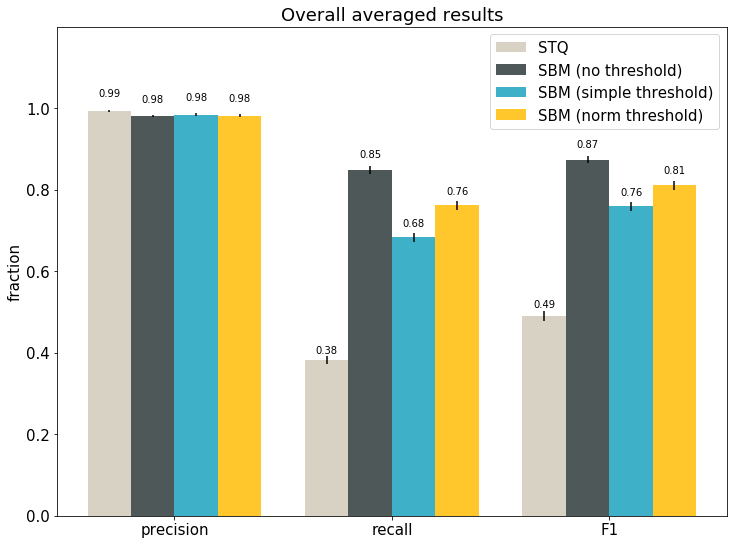

In [12]:
def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 10})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

ind = np.arange(3)
width = 0.2
plt.rcParams.update({'font.size': 15}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - width, get_means(results_stq), width, color='#d8d2c4', yerr=get_ses(results_stq))
rects2 = ax.bar(ind, get_means(results_sbm_0), width, color='#4f5858', yerr=get_ses(results_sbm_0))
rects3 = ax.bar(ind + width, get_means(results_sbm_53), width, color='#3eb1c8', yerr=get_ses(results_sbm_53))
rects4 = ax.bar(ind + 2*width, get_means(results_sbm_047), width, color='#ffc72c', yerr=get_ses(results_sbm_047))

ax.set_ylabel('fraction')
ax.set_title('Overall averaged results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
          ('STQ', 'SBM (no threshold)', 'SBM (simple threshold)', 'SBM (norm threshold)'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
autolabel(ax, rects4)

plt.show() 

STQ is still the worst approach with F1 of 49%. The best is SBM without any threshold (which cannot be used in practise). Normalized threshold results in better overall F1 than simple threshold (F1 81% vs. 76%). The differences in precision are not large enough to have a practical impact.

Vertical black lines on top of the bars represent confidence intervals. They do not overlap, which means that we can be 95% sure that the ranking of the matching approaches stays the same, even if we tested every single document in the system.

Let's also plot similar comparison for each style separately. 

In [13]:
def get_results_style(results, style):
    results = results.get(dfk.EVAL_SPLIT_METRICS)
    results = results.iloc[:,[7,8,9]][results['style'] == style]
    return list(results.to_records(index=False)[0])

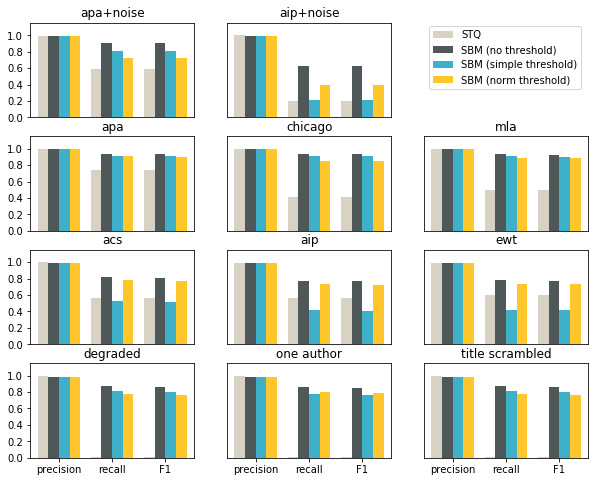

In [14]:
f, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 8))
ind = np.arange(3)
width = 0.2

styles = [['apa-noise', 'american-institute-of-physics-noise'],
          ['apa', 'chicago-author-date', 'modern-language-association'],
          ['american-chemical-society', 'american-institute-of-physics', 'elsevier-without-titles'],
          ['degraded_all_authors', 'degraded_one_author', 'degraded_title_scrambled']]
titles = [['apa+noise', 'aip+noise'],
          ['apa', 'chicago', 'mla'],
          ['acs', 'aip', 'ewt'],
          ['degraded', 'one author', 'title scrambled']]

for i in range(4):
    for j in range(3):
        if len(styles) <= i or len(styles[i]) <= j:
            continue
        rects1 = axes[i, j].bar(ind-width, get_results_style(results_style_stq, styles[i][j]), width, color='#d8d2c4')
        rects2 = axes[i, j].bar(ind, get_results_style(results_style_sbm_0, styles[i][j]), width, color='#4f5858')
        rects3 = axes[i, j].bar(ind+width, get_results_style(results_style_sbm_53, styles[i][j]), width, color='#3eb1c8')
        rects4 = axes[i, j].bar(ind+2*width, get_results_style(results_style_sbm_047, styles[i][j]), width, color='#ffc72c')
        axes[i, j].set_title(titles[i][j])

axes[0, 0].set_xticks(ind + width / 2)
axes[0, 0].set_xticklabels(('precision', 'recall', 'F1'))
axes[0, 2].legend((rects1[0], rects2[0], rects3[0], rects4[0]),
                  ('STQ', 'SBM (no threshold)', 'SBM (simple threshold)', 'SBM (norm threshold)'),
                  loc=3, bbox_to_anchor=(0, 0.25))

for i in range(3):
    for j in range(3):
        axes[i, j].xaxis.set_ticks_position('none') 
for i in range(4):
    for j in [1,2]:
        axes[i, j].yaxis.set_ticks_position('none')
axes[0, 2].axis('off')

plt.ylim(0, 1.15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

As we can see, SBM with no threshold outperforms STQ for every style. SBM with a simple threshold is worse than STQ for styles that do not include the title (acs, aip, ewt). SBM with a normalized threshold is worse than SBM with no threshold, but in every case better than STQ.